# Import necessary library

In [221]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from scipy.stats import skew, norm, zscore
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PolynomialFeatures
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Explore data

In [222]:
# Read train and test data
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

# Combine train and test data for data cleaning
y = train.SalePrice
train = train.drop("SalePrice", axis=1)

train["train_test"] = 1
test["train_test"] = 0

X = pd.concat([train, test])

# Create categorical columns
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()
# Create numeric columns
numerical_cols = train.select_dtypes(exclude=["object"]).columns.tolist()

"""
Split features further: continuous, discrete, ordinal, nominal, alphanumerical and binary

Continuous features: 'LotFrontage', 'LotArea', 'MasVnrArea', '
    BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
    '2ndFlrSF', 'LowQualFinSF','GrLivArea', 'GarageArea', 'WoodDeckSF', 
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'

Discrete features: 'MSSubClass', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 
    'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'BsmtFullBath', 
    'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr'

Ordinal features: 'OverallQual', 'OverallCond', 'LotShape', 'ExterQual', 'ExterCond', 
    'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
    'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
    'PavedDrive'(Ordinal or nominal?), 'PoolQC', 'Fence'(Ordinal or nominal?)

Nominal features: 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 
    'LandSlope', 'Neighborhood', 'Condition1','Condition2', 'RoofStyle', 'RoofMatl', 
    'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 
    'Functional', 'GarageType', 'MiscFeature', 'SaleType','SaleCondition', 'MSSubClass'

Alphanumerical features: 'LotConfig','BldgType','HouseStyle'

Binary features: CentralAir

Temp features: train_test

N.B. MSSubClass appears to be a discrete features but is infact a nominal one


"""

train["MSSubClass"] = train["MSSubClass"].astype("str")
test["MSSubClass"] = test["MSSubClass"].astype("str")
X["MSSubClass"] = X["MSSubClass"].astype("str")
numerical_cols.remove("MSSubClass")
categorical_cols.append("MSSubClass")

# Continuous: lien tuc
cont_features = [
    "LotFrontage",
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
]

# Discrete: roi rac
disc_features = [
    "MSSubClass",
    "YearBuilt",
    "YearRemodAdd",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "MoSold",
    "YrSold",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
]

# Ordinal:
ord_features = [
    "OverallQual",
    "OverallCond",
    "LotShape",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "PoolQC",
    "Fence",
]

# Nominal
nom_features = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Alley",
    "LandContour",
    "Utilities",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "Heating",
    "Electrical",
    "Functional",
    "GarageType",
    "MiscFeature",
    "SaleType",
    "SaleCondition",
]

# Alphanumerical
alpnum_features = ["LotConfig", "BldgType", "HouseStyle"]
# Binary
bin_features = ["CentralAir"]

temp_features = ["train_test"]


# Data Visualisation

In [223]:
# Import library
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Target Feature

<Axes: xlabel='SalePrice', ylabel='Count'>

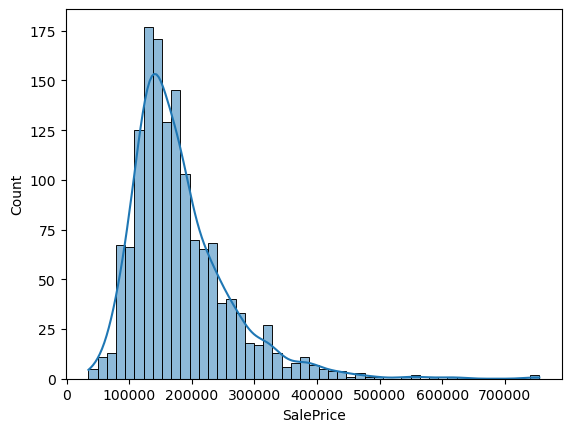

In [224]:
sns.histplot(da.y, kde = True)

Slight skew in SalePrice to the right, might be worth log(1+x) transforming the target

Look at correlation between target and features

In [225]:
correlation = pd.concat([train[numerical_cols], y], axis = 1).corr()

correlation[['SalePrice']].sort_values(by=['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


### Numerical Features

In [226]:
show = False

In [227]:
def plot_num_hist(show):
    if (show == True):
        fig = plt.figure(figsize=(20, 40))
        ax = []
        for i, val in enumerate(numerical_cols):
            ax.append(fig.add_subplot(10, 4, i+1))
            ax.append(sns.histplot(train[val].dropna(), kde=True))
            fig.tight_layout()
plot_num_hist(show)

Mostly 0 area for some features e.g. Porch and Pools

In [228]:
def plot_num_box(show):
    if (show == True):
        fig = plt.figure(figsize=(20, 40))
        ax = []
        for i, val in enumerate(numerical_cols):
            ax.append(fig.add_subplot(10, 4, i+1))
            ax.append(sns.boxplot(train[val].dropna()))
            fig.tight_layout()
plot_num_box(show)

Most extreme outliers are: 'LotFrontage','LotArea','BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea'

Less extreme outliers are: 'MasVnrArea', '1stFlrSF', 'Fireplaces', 'GarageCars', 'OpenPorchSF'

Mostly 0s: BsmtFinSF2, LowQualFinSF, 'BsmtHalfBalf','KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'

Look for quasi-constant features (features with >95% of the same values here)

In [229]:
overfit_num = []
for col in numerical_cols:
    counts = train[col].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) > 0.95:
        overfit_num.append(col)

overfit_num

['LowQualFinSF',
 'KitchenAbvGr',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'train_test']

Look for multicollinearity of over 80%

In [230]:
def plot_num_corr(show):
    if (show == True):
        plt.figure(figsize=(14, 12))
        sns.heatmap(correlation, mask=correlation<0.8, 
                    linecolor = 'black', linewidths=.5)
plot_num_corr(show)

GarageYrBlt and YearBuilt

1stFlrSF and TotalBsmtSF

GarageArea and GarageCars

TotRmsAbvGrd and GrLivArea

In [231]:
def plot_num_reg(show):
    if (show == True):
        fig = plt.figure(figsize=(20, 40))
        ax = []
        for i, val in enumerate(numerical_cols):
            ax.append(fig.add_subplot(10, 4, i+1))
            ax.append(sns.regplot(x = val, y = 'SalePrice', 
                                  data = pd.concat([train[numerical_cols], y],
                                                   axis = 1).dropna()))
            fig.tight_layout()
plot_num_reg(show)

Features with mostly 0s have poor correlations with SalePrice.

YrSold and MoSold have no correlation with the SalePrice and should be removed.


### Categorical Features

In [232]:
def plot_cat_count(show):
    if show == True:
        fig = plt.figure(figsize=(20, 40))
        ax = []
        
        for i, val in enumerate(categorical_cols):
            ax.append(fig.add_subplot(11, 4, i+1))
            ax.append(sns.countplot(data = train, x = val))
        fig.tight_layout()
plot_cat_count(show)

Highest Cardinality Features: 'Neighborhood', 'Exterior1st', 'Exterior2nd'

In [233]:
overfit_cat = []
for col in categorical_cols:
    counts = train[col].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) > 0.95:
        overfit_cat.append(col)
overfit_cat

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [234]:
def cat_box(show):
    if show == True:
        fig = plt.figure(figsize = (20, 40))
        for i, val in enumerate(categorical_cols):
            sns.catplot(x = val, y = 'SalePrice', data = pd.concat([
                train[categorical_cols], y
            ], axis = 1), kind='box')
            fig.tight_layout()
# cat_box(show)

### NA values

              Features
PoolQC        0.995205
MiscFeature   0.963014
Alley         0.937671
Fence         0.807534
MasVnrType    0.597260
FireplaceQu   0.472603
LotFrontage   0.177397
GarageYrBlt   0.055479
GarageCond    0.055479
GarageType    0.055479
GarageFinish  0.055479
GarageQual    0.055479
BsmtExposure  0.026027
BsmtFinType2  0.026027
BsmtCond      0.025342
BsmtQual      0.025342
BsmtFinType1  0.025342
MasVnrArea    0.005479
Electrical    0.000685


<Axes: xlabel='None', ylabel='Features'>

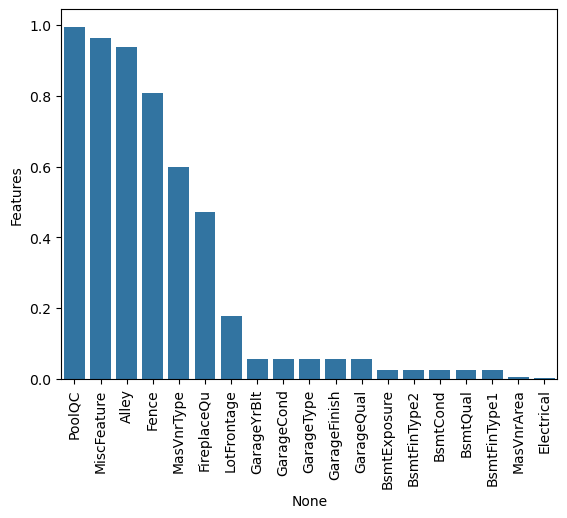

In [235]:
na_df = pd.DataFrame({"Features": train.isnull().sum(axis=0)/len(train)}
                     ).sort_values(by = 'Features', ascending=False)
na_df = na_df.loc[na_df['Features'] != 0]
print(na_df)
plt.xticks(rotation='vertical')
sns.barplot(x = na_df.index, y = na_df.Features)

# Data cleaning

In [236]:
"""
In the data_visualisation.ipynb file, we defined useless features:

1)No Correlation with SalePrice: 'YrSold', 'MoSold'

2)Quasi-constant Categorical: 'Street', 
    'Utilities', 'Condition2', 'RoofMatl', 'Heating'

3)Quasi-constant Numerical: 'LowQualFinSF', 
    'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal'
"""

# Removing useless features
train = train.drop(
    [
        "MoSold",
        "Street",
        "Utilities",
        "Condition2",
        "RoofMatl",
        "Heating",
        "LowQualFinSF",
        "KitchenAbvGr",
        "MiscVal",
        "PoolArea",
    ],
    axis=1,
)
test = test.drop(
    [
        "MoSold",
        "Street",
        "Utilities",
        "Condition2",
        "RoofMatl",
        "Heating",
        "LowQualFinSF",
        "KitchenAbvGr",
        "MiscVal",
        "PoolArea",
    ],
    axis=1,
)

# Keep'YrSold' for time being as may be useful in feature engineering.

In [237]:

# Removing outliers
"""We use IQR"""
"""Calculate the upper and lower limits"""
worst_outliers = ['LotFrontage','LotArea','BsmtFinSF1', 
                  'TotalBsmtSF', 'GrLivArea']

Q1 = train[worst_outliers].quantile(0.25)
Q3 = train[worst_outliers].quantile(0.75)

IQR = Q3 - Q1
lower = Q1 - 10 * IQR
upper = Q3 + 10 * IQR


upper_index = np.unique(np.where(train[worst_outliers] >= upper)[0])
lower_index = np.unique(np.where(train[worst_outliers] <= lower)[0])

train = train.drop(index = upper_index)
train = train.drop(index = lower_index)



In [238]:
# Filling NA values
"""Firstly, we combine train and test data again to account 
for the outliers we removed"""

X = pd.concat([train, test])

na_df = pd.DataFrame({"Features": X.isnull().sum(axis=0) / len(X)}).sort_values(
    by="Features", ascending=False
)
na_df = na_df.loc[na_df["Features"] != 0]

none_cols = [
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "GarageType",
    "BsmtCond",
    "BsmtExposure",
    "BsmtQual",
    "BsmtFinType2",
    "BsmtFinType1",
    "MasVnrType",
]

for col in none_cols:
    X[col] = X[col].fillna("None")

zero_cols = [
    "MasVnrArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "GarageYrBlt",
    "GarageCars",
    "TotalBsmtSF",
    "BsmtUnfSF",
    "GarageArea",
]
for col in zero_cols:
    X[col] = X[col].fillna(0)


mode_cols = ["KitchenQual", "Electrical", "SaleType", 
             "Exterior1st", "Exterior2nd"]
for col in mode_cols:
    X[col] = X.groupby("Neighborhood")[col].transform(lambda x: x.fillna(x.mode()[0]))

X["MSZoning"] = X.groupby("MSSubClass")["MSZoning"].transform(
    lambda x: x.fillna(x.mode()[0])
)

X["Functional"] = X["Functional"].fillna("Typ")

In [239]:
# Mapping Categorical Features
X["CentralAir"] = X["CentralAir"].map({"N": 0, "Y": 1})
X["LotShape"] = X["LotShape"].map({"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4})
X["LandSlope"] = X["LandSlope"].map({"Gtl": 1, "Mod": 2, "Sev": 3})
QualCondMap = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
for col in [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "GarageQual",
    "GarageCond",
    "KitchenQual",
    "HeatingQC",
    "FireplaceQu",
    "PoolQC",
]:
    X[col] = X[col].map(QualCondMap)
X["BsmtExposure"] = X["BsmtExposure"].map(
    {"None": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
)
X["GarageFinish"] = X["GarageFinish"].map({"None": 0, "Unf": 1, "RFn": 2, "Fin": 3})
X["PavedDrive"] = X["PavedDrive"].map({"N": 1, "P": 2, "Y": 3})
X["Fence"] = X["Fence"].map({"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "None": 0})


# Feature engineering

In [240]:
"""Add some new features representing totals and presence"""

X["TotalLot"] = X["LotFrontage"] + X["LotArea"]
X["TotalBsmtFin"] = X["BsmtFinSF1"] + X["BsmtFinSF2"]
X["TotalSF"] = (
    X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
)  # Got rid of 1stFlrSF ealier so this is new total
X["TotalSFinclGarage"] = (
    X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
)
X["TotalBath"] = (
    X["FullBath"]
    + (0.5 * X["HalfBath"])
    + X["BsmtFullBath"]
    + (0.5 * X["BsmtHalfBath"])
)
X["TotalPorch"] = (
    X["OpenPorchSF"] + X["EnclosedPorch"] + X["ScreenPorch"] + X["3SsnPorch"]
)
X["OverallQxOverallC"] = (
    X["OverallCond"] * X["OverallQual"]
)  # Multiplying together gives better score
X["ExtQxOverallQ"] = (
    X["OverallQual"] * X["ExterQual"]
)  # Multiplying together gives better score
X["RemodYrBuilt"] = X["YearRemodAdd"] - X["YearBuilt"]
X["YrsSinceRemod"] = X["YrSold"] - X["YearRemodAdd"]
X = X.drop("YrSold", axis=1)

X["HasPool"] = X["PoolQC"].apply(lambda x: 1 if x > 0 else 0)
X["HasPorch"] = X["TotalPorch"].apply(lambda x: 1 if x > 0 else 0)
X["HasBsmt"] = X["TotalBsmtFin"].apply(lambda x: 1 if x > 0 else 0)
X["HasGarage"] = X["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
X["HasFireplace"] = X["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)
X["Has2ndFloor"] = X["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
X["HasWoodDeck"] = X["WoodDeckSF"].apply(lambda x: 1 if x > 0 else 0)
X["HasMasVnr"] = X["MasVnrArea"].apply(lambda x: 1 if x > 0 else 0)
X["HasAlley"] = X["Alley"].apply(lambda x: 0 if x == "None" else 1)
X["Has3SsnPorch"] = X["3SsnPorch"].apply(lambda x: 1 if x > 0 else 0)
X["HasScreenPorch"] = X["ScreenPorch"].apply(lambda x: 1 if x > 0 else 0)
# X['HasEnclosedPorch'] = X['EnclosedPorch'].apply(lambda x: 1 if x > 0 else 0)
# X = X.drop('PoolQC',axis = 1)

X["SimplMSZoning"] = X.MSZoning.map({"C (all)": 1, "RH": 2, "RM": 2, "RL": 3, "FV": 4})
X["GarageCarsxArea"] = X["GarageCars"] * X["GarageArea"]
X["TotalSFxOverallQual"] = X["TotalSF"] * X["OverallQual"]  # Very Good Feature
X["GrLivAreaxOverallQual"] = X["GrLivArea"] * X["OverallQual"]  # Very Good Feature
X["SimplMSZoningxTotalSF"] = X["SimplMSZoning"] * X["TotalSF"]  # Very Good Feature
X["SimplMSZoning+OverallQual"] = (
    X["SimplMSZoning"] + X["OverallQual"]
)  # Very Good Feature
X["SimplMSZoning+YearBuilt"] = X["SimplMSZoning"] + X["YearBuilt"]  # Very Good Feature
X["LotAreaxOverallQual"] = X["LotArea"] * X["OverallQual"]  # Could be worth adding
# X['KitchenQualxOverallQxOverallC'] = X['KitchenQual'] * X['OverallQxOverallC']

numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()
numerical_cols.remove("train_test")
correlation = pd.concat([X[numerical_cols], y], axis=1).corr()
correlation = abs(correlation[["SalePrice"]]).sort_values(
    ["SalePrice"], ascending=False
)
print(correlation)

correlation = correlation.index.tolist()
print(correlation[1:11])

# Polynomial features of the best 10
cols = correlation[1:11]

for col in cols:
    X[col + "-2"] = X.loc[:, col] ** 2
    X[col + "-3"] = X.loc[:, col] ** 3
    X[col + "-sqrt"] = np.sqrt(np.absolute(X.loc[:, col]))


                           SalePrice
SalePrice                   1.000000
TotalSFxOverallQual         0.855686
GrLivAreaxOverallQual       0.831525
ExtQxOverallQ               0.810576
TotalSFinclGarage           0.808701
OverallQual                 0.791008
SimplMSZoningxTotalSF       0.787139
SimplMSZoning+OverallQual   0.783920
TotalSF                     0.781254
GrLivArea                   0.707425
ExterQual                   0.681752
GarageCarsxArea             0.680300
KitchenQual                 0.659254
GarageCars                  0.642134
TotalBath                   0.632224
GarageArea                  0.622699
TotalBsmtSF                 0.612692
1stFlrSF                    0.604778
BsmtQual                    0.584461
OverallQxOverallC           0.565207
FullBath                    0.561264
GarageFinish                0.548038
TotRmsAbvGrd                0.533471
SimplMSZoning+YearBuilt     0.521924
YearBuilt                   0.520955
YrsSinceRemod               0.507896
Y

#### Fix Skewage in Features

In [241]:
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
numerical_cols.remove('train_test')

skew_features = X[numerical_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[abs(skew_features) > 0.5]
print("There are {} numerical features with abs Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
print(skewness)

There are 78 numerical features with abs Skew > 0.5 :
                                  Skew
TotalSFxOverallQual-3        29.350649
TotalSF-3                    24.174732
SimplMSZoningxTotalSF-3      22.409228
TotalSFinclGarage-3          21.590796
GrLivAreaxOverallQual-3      18.011051
HasPool                      16.964771
LotArea                      12.809673
TotalSFxOverallQual-2        12.009673
3SsnPorch                    11.354131
LotAreaxOverallQual          11.257841
GrLivArea-3                  10.434732
Has3SsnPorch                  8.695256
TotalSF-2                     8.018015
GrLivAreaxOverallQual-2       7.423671
SimplMSZoningxTotalSF-2       6.595081
TotalSFinclGarage-2           6.575586
LandSlope                     4.964680
BsmtFinSF2                    4.137116
EnclosedPorch                 4.001844
GrLivArea-2                   3.960467
ScreenPorch                   3.952500
BsmtHalfBath                  3.922798
ExtQxOverallQ-3               3.138966
HasScreenP

In [242]:
pt = PowerTransformer()
X[high_skew.index] = pt.fit_transform(X[high_skew.index])

skew_features = X[numerical_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[abs(skew_features) > 0.5]
print("There are {} numerical features with abs Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
print(skewness)

There are 21 numerical features with abs Skew > 0.5 :
                     Skew
HasPool         16.964771
Has3SsnPorch     8.695256
3SsnPorch        8.695256
LandSlope        4.204173
BsmtHalfBath     3.698807
ScreenPorch      2.915483
HasScreenPorch   2.915483
BsmtFinSF2       2.348657
EnclosedPorch    1.884116
GarageCond       1.539179
GarageQual       1.090551
BsmtCond         0.646719
RemodYrBuilt     0.589951
HalfBath         0.532263
LotShape        -0.594514
HasBsmt         -0.782887
HasPorch        -0.873586
PavedDrive      -2.771142
CentralAir      -3.484027
GarageYrBlt     -3.821161
HasGarage       -3.947070


#### Check numerical data used in training

In [243]:
def plot_num_final(show):
    if(show==True):
        numerical_cols = X.select_dtypes(exclude=['object']).columns
        fig = plt.figure(figsize = (20,100))
        ax = []
        for i,val in enumerate(numerical_cols):
            ax.append(fig.add_subplot(25,5,i+1))
            ax.append(sns.regplot(x=val,y='SalePrice', data = pd.concat(
            [X.loc[X.train_test==1],y],axis=1)))
        plt.show()
        fig.tight_layout()
plot_num_final(show)

In [244]:
# Convert rest of Categorical Features using dummies
X = pd.get_dummies(X)

# Modeling


#### Write Learning Curve and Validation Curve function to determine whether model is good fit

In [245]:
def plot_learning_curve(estimator, X, y, cv, train_sizes):
    plt.figure()
    plt.title(str(estimator))
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs = -1, 
                                                            train_sizes=train_sizes, scoring = 'neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r',
             label = 'Training score')

    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g',
             label = 'Cross-validation score')
    plt.legend(loc = 'best')
    return plt    

In [246]:
def plot_validation_curve(model, X, y, param_name, param_range, cv):
    train_score, test_score = validation_curve(model, X, y, 
                                               param_name=param_name,
                                               param_range=param_range,
                                               cv = cv, 
                                               scoring = 'neg_mean_squared_error')
    train_score_mean = np.mean(train_score, axis = 1)
    test_score_mean = np.mean(test_score, axis = 1)
    
    train_score_std = np.std(train_score, axis = 1)
    test_score_std = np.std(test_score, axis = 1)
    
    plt.plot(param_range, train_score_mean, label = "Training Score",
             color = 'darkblue')
    plt.fill_between(param_range, train_score_mean - train_score_std, 
                     train_score_mean + train_score_std, color = 'lightgreen')
    
    plt.plot(param_range, test_score_mean, label = "Training Score",
             color = 'darkblue')
    plt.fill_between(param_range, test_score_mean - test_score_std, 
                     test_score_mean + test_score_std, color = 'lightgreen')
    
    plt.title(str(model))
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.tight_layout()
    plt.legend(loc = 'best')

#### Split back into Train and Test dataset

In [247]:
X_train = X[X.train_test == 1].drop(['train_test'], axis=1)
X_test = X[X.train_test == 0].drop(['train_test'], axis=1)

#### Apply log transformation on SalePrice to reduce the skewage

<Axes: xlabel='SalePrice', ylabel='Count'>

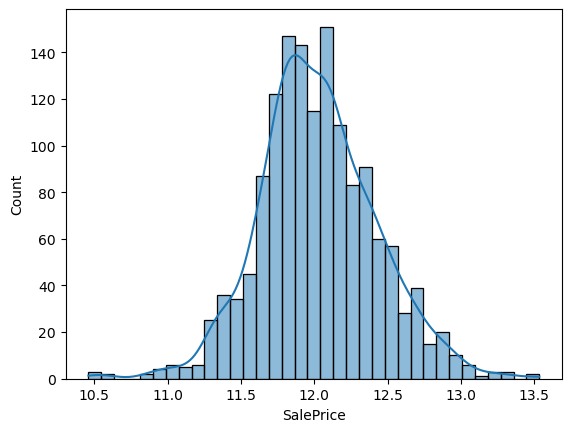

In [248]:
y = np.log(y)
sns.histplot(y, kde = True)

#### Removing train constant and quasi-constant columns which may overfit the data. MSZoning_C is example of this, it is over 99% 0s but has very large coefficients in my model

#### Over 99.94% Corresponds to Constant. Over 99.93% Corresponds to all constant but 1. Over 99.86% corresponds to all constant but 2. Over 99.79% corresponds to all constant but 3. And so on...

In [249]:
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) > 0.9994:
        overfit.append(i)
overfit.append("MSZoning_C (all)") # Largest coefficients in Regularization models but mostly 0
print(overfit)

['HasAlley', 'MSSubClass_150', 'MSZoning_C (all)']


In [250]:
X_train = X_train.drop(overfit, axis = 1)
X_test = X_test.drop(overfit, axis = 1)

#### Try applying PCA as we have a large number of correlated features. This didn't improve results so I have not used it

In [252]:
from sklearn.decomposition import PCA
print(len(X_train.columns))

pca = PCA()

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

component_names = [f"PC{i+1}" for i in range(X_train.shape[1])]

X_train = pd.DataFrame(X_train, columns=component_names, index = X_train.index)

component_names = [f"PC{i+1}" for i in range(X_test.shape[1])]

X_test = pd.DataFrame(X_test, columns=component_names, index = X_test.index)


280


#### Finally, remove outliers which were found to have a negative impact on the regression. I will only remove the very worst outliers which sigma >=4 to start with. Removing outliers with sigma >= 3 made results worse on LB but I will try remove outliers shared between models at this sigma at a later stage

In [253]:
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff ** 2)
    
    return np.sqrt(sum_sq / len(y_pred))

# RMSE(sigma^) = sqrt(MSE(sigma^)) = sqrt(E[(sigma^ - sigma)^2])

In [ ]:
def find_outliers(model, X_train, y, sigma):
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X_train), index = y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X_train, y)
        y_pred = pd.Series(model.predict(X_train), index = y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = np.mean(resid)
    std_resid = np.std(resid)
    
    # calculate z statistics, define outliers to be where |z| > sigma
    z = (resid - np.mean(resid)) / np.std(resid)
    
    outliers = z[abs(z) > sigma].index
    
    # print and plot the results
    print(str(model))
    print('R2=',model.score(X_train,y))
    print('rmse=',rmse(y, y_pred))
    print('mean of residuals:',resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())
    print('---------------------------------------')
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title(str(model))
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title(str(model))
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    plt.title(str(model))
    
    return outliers.tolist()
    